Import NIPS csv, remove unwanted columns, sample 10 papers for speed purposes, remove punctuation and make lowercase.

In [99]:
import pandas as pd
import os
import re

os.chdir('../data')

papers = pd.read_csv("papers.csv")

# Remove the columns
papers = papers.drop(columns=['id', 'title', 'abstract', 
                              'event_type', 'pdf_name', 'year'], axis=1)
# sample only 10 papers - for demonstration purposes (speed)
papers = papers.sample(10)

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub(r'[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

6621    independence clustering (without a matrix)\n\n...
1738    742\n\ndeweerth and mead\n\nan analog vlsi mod...
2432    learning the 2-d topology of images\n\nyoshua ...
512     a superadditive-impairment theory\nof optic ap...
1633    approximate planning in pomdps with\nmacro-act...
Name: paper_text_processed, dtype: object

Change each sentence to a list, remove all punctuation and extra characters

In [100]:
%%time
import gensim
from gensim.utils import simple_preprocess

def toWords(data):
    for line in data:
        yield(gensim.utils.simple_preprocess((line), deacc=True)) # Simple_preprocess with deacc=True is the same as the regex strip-lowercase above
        # Yield returns a generator function, not the result and will only return the result when the variable the generator is assigned to is called
        # reduces memory storage for large objects
        
data = papers.paper_text_processed.values.tolist()
dataWords = list(toWords(data))

print(len(dataWords))


10
Wall time: 110 ms


Bi-grams/tri-grams/quad-grams are groups of 2/3/4 words that regullarly occur together. These are useful for aiding topic analysis as we can generate topics for mono/bi/tri/quad-grams etc

We can use Phrases model from gensim to create the bi-grams, the min_count & threshold control the combination of the words, higher min_count & threshold = harder to combine.

Possible variables to solve for in the statistical analysis?

In [101]:
%%time
# Build the bigram and trigram models
mCount = 5 # minimum no of occurances to be considered a phrase
thold = 100 # higher threshold fewer phrases.

bigram = gensim.models.Phrases(dataWords, min_count=mCount, threshold=thold) 
trigram = gensim.models.Phrases(bigram[dataWords], threshold=thold)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Wall time: 752 ms


Given the models above we can now create the bi/tri-grams. remove the stop words, make the grams and then lemmatize (group variations of the same grams - grouping different forms of the same word)

In [102]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stopWords = stopwords.words('english') # removes connectives n stuff (and, for, a, to etc)
stopWords.extend(['from', 'subject', 're', 'edu', 'use'])

#Define helper fn's for the stuff

def RemoveStopWords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]
    # returns a list or words for each text, with no stopwords
    
def MakeBigrams(texts):
    return[bigram_mod[doc] for doc in texts]
    # returns list of bigrams for each text
    
def MakeTrigrams(texts):
    return[trigram_mod[bigram_mod[doc]] for doc in texts]
    # returns a list of trigrams for each text by creating bigrams first, then looking at connected words to form tri-grams
    
def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    textsOut = []
    count = 0
    for sent in texts:
        count += 1
        doc =  nlp(" ".join(sent))
        textsOut.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return textsOut
    # I accidentally indented the return, which led to only using 1 document to do analysis on

Call the functions in order

In [103]:
import spacy

# strip stopwords
dataWords_Nostop = RemoveStopWords(dataWords)

print(len(dataWords_Nostop))

# make bigrams
dataWords_Bigrams = MakeBigrams(dataWords_Nostop)

print(len(dataWords_Bigrams))

# initialise english spacy model
# had to install 2.2.0 from github directly with pip3 to get it to work
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# lemmatize, keeping only nouns, adjectives, verbs, adverbs
data_lemmatized = lemmatize(dataWords_Bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(len(data_lemmatized))



10
10
10


We now want to generate the vocabulary of the documents and the corpus(documents)

In [104]:
import gensim.corpora as corpora

# Create vocab dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create corpus
texts = data_lemmatized

# generate a dictionary of the word id's vs frequency of occurance == vocabulary vectors for each text
corpus = [id2word.doc2bow(text) for text in texts]

print(len(corpus))

10


We now want to build and train an LDA model. We need to specify # of topics (and optimize this). 

Additional import parameters:
chunksize = how many documents are processed at once in the training (larger chunksize --> faster training if memory allows)

passes = how many times the whole corpus is used to train the model

alpha and beta are set to 'symmetric' and 'none' respectively by default.

In [105]:
n_topics = 10
c_size = 100
n_passes = 10

ldaModel = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=n_topics,
                                      random_state=100,
                                      chunksize=c_size,
                                      passes=n_passes,
                                      per_word_topics=True)

In [106]:
from pprint import pprint

pprint(ldaModel.print_topics())
doc_lda = ldaModel[corpus]

[(0,
  '0.034*"function" + 0.028*"model" + 0.021*"set" + 0.020*"error" + '
  '0.019*"variable" + 0.019*"decomposition" + 0.014*"use" + 0.014*"inference" '
  '+ 0.012*"result" + 0.010*"accuracy"'),
 (1,
  '0.001*"model" + 0.001*"input" + 0.001*"set" + 0.001*"distribution" + '
  '0.001*"process" + 0.001*"figure" + 0.001*"network" + 0.001*"use" + '
  '0.001*"test" + 0.001*"datum"'),
 (2,
  '0.022*"curve" + 0.020*"set" + 0.016*"datum" + 0.016*"unit" + 0.015*"error" '
  '+ 0.013*"function" + 0.013*"use" + 0.012*"figure" + 0.011*"network" + '
  '0.010*"polynomial"'),
 (3,
  '0.023*"cluster" + 0.017*"distribution" + 0.017*"process" + 0.016*"sample" + '
  '0.015*"test" + 0.014*"case" + 0.013*"set" + 0.013*"problem" + '
  '0.010*"independence" + 0.010*"element"'),
 (4,
  '0.019*"state" + 0.018*"macro_action" + 0.017*"resolution" + 0.016*"value" + '
  '0.014*"number" + 0.013*"grid_point" + 0.012*"action" + 0.012*"figure" + '
  '0.011*"step" + 0.011*"belief_space"'),
 (5,
  '0.017*"image" + 0.015

Use gensim to calculate baseline coherence score - Higher coherence = better

In [107]:
from gensim.models import CoherenceModel

# Calculate base coherence score

coherence_model_lda = CoherenceModel(model=ldaModel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4672027415572166


Hyperparemter Tuning:

HyperParameters = Input parameters of the model set by the data scientist. Eg number of topics.

Model Parameters =  Parameters that the model learns, e.g. weights of each word

we now want to optimize the following hyperparameters:
No of topics (K)
Alpha param (doc-topic density)
Beta param (topic-word density)

optimise in sequence by varying and aiming to minimise C_v

In [108]:
# helper function to compute a coherence value given different params
def calc_coherence(corpus, dictionary, k, a, b):
    
    ldaModel = gensim.models.LdaMulticore(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=k,
                                          random_state=100,
                                          chunksize=c_size,
                                          passes=n_passes,
                                          alpha=a,
                                          eta=b,
                                          per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=ldaModel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

minimise across all 3 parameters using the helper fn

In [42]:
%%time 

import numpy as np
import tqdm
import time

grid = {}
grid['Validation_Set'] = {}

# Topics
minK = 2
maxK = 11
step = 1
rangeK = range(minK, maxK, step)

# Alpha
alpha = list(np.arange(0.1, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta
beta = list(np.arange(0.1, 1, 0.3))
beta.append('symmetric')

# Generate validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus[:int(num_of_docs*0.7)], corpus]
# can test against 25/50/75 % etc

corpus_title = ['70% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

print(len(corpus_sets[0]))
if 1 == 1:
    pbar = tqdm.tqdm(total=360)
    
    #iterate through validation corpuses, thus comparing different sets
    for i in range(len(corpus_sets)):
        # iterate topics
        for k in rangeK:
            # iterate alpha
            for a in alpha:
                # iterate beta
                for b in beta:
                    #get c_v for given params
                    cv = calc_coherence(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    pbar.update(1)

    pd.DataFrame(model_results).to_csv('lda_optim_results.csv')
    pbar.close()






  0%|                                                                                                                                                                                   | 0/360 [00:00<?, ?it/s]

7







  0%|▍                                                                                                                                                                        | 1/360 [00:15<1:30:25, 15.11s/it]




  1%|▉                                                                                                                                                                        | 2/360 [00:31<1:33:07, 15.61s/it]




  1%|█▍                                                                                                                                                                       | 3/360 [00:49<1:36:42, 16.25s/it]




  1%|█▉                                                                                                                                                                       | 4/360 [01:06<1:37:03, 16.36s/it]




  1%|██▎                                                                                                                                       

 10%|████████████████▊                                                                                                                                                       | 36/360 [09:59<1:29:08, 16.51s/it]




 10%|█████████████████▎                                                                                                                                                      | 37/360 [10:16<1:28:35, 16.46s/it]




 11%|█████████████████▋                                                                                                                                                      | 38/360 [10:32<1:28:20, 16.46s/it]




 11%|██████████████████▏                                                                                                                                                     | 39/360 [10:49<1:28:48, 16.60s/it]




 11%|██████████████████▋                                                                                                                            

 20%|█████████████████████████████████▏                                                                                                                                      | 71/360 [20:00<1:21:40, 16.96s/it]




 20%|█████████████████████████████████▌                                                                                                                                      | 72/360 [20:17<1:21:06, 16.90s/it]




 20%|██████████████████████████████████                                                                                                                                      | 73/360 [20:34<1:20:42, 16.87s/it]




 21%|██████████████████████████████████▌                                                                                                                                     | 74/360 [20:51<1:20:34, 16.91s/it]




 21%|███████████████████████████████████                                                                                                            

 29%|█████████████████████████████████████████████████▏                                                                                                                     | 106/360 [30:06<1:13:54, 17.46s/it]




 30%|█████████████████████████████████████████████████▋                                                                                                                     | 107/360 [30:23<1:13:44, 17.49s/it]




 30%|██████████████████████████████████████████████████                                                                                                                     | 108/360 [30:40<1:12:57, 17.37s/it]




 30%|██████████████████████████████████████████████████▌                                                                                                                    | 109/360 [30:58<1:12:35, 17.35s/it]




 31%|███████████████████████████████████████████████████                                                                                            

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 141/360 [40:06<1:02:18, 17.07s/it]




 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 142/360 [40:25<1:03:31, 17.49s/it]




 40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 143/360 [40:43<1:04:32, 17.84s/it]




 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 144/360 [41:02<1:04:49, 18.01s/it]




 40%|███████████████████████████████████████████████████████████████████▎                                                                           

 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 176/360 [50:28<55:41, 18.16s/it]




 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                      | 177/360 [50:45<54:37, 17.91s/it]




 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 178/360 [51:02<53:23, 17.60s/it]




 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                     | 179/360 [51:19<53:12, 17.64s/it]




 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                          

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 211/360 [1:00:13<41:07, 16.56s/it]




 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 212/360 [1:00:30<41:16, 16.73s/it]




 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 213/360 [1:00:47<40:55, 16.71s/it]




 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 214/360 [1:01:04<40:30, 16.65s/it]




 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                           

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 246/360 [1:10:50<33:41, 17.73s/it]




 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 247/360 [1:11:07<33:08, 17.60s/it]




 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 248/360 [1:11:24<32:27, 17.39s/it]




 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 249/360 [1:11:44<33:26, 18.07s/it]




 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 281/360 [1:21:38<24:48, 18.84s/it]




 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 282/360 [1:21:58<24:51, 19.12s/it]




 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 283/360 [1:22:17<24:44, 19.29s/it]




 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 284/360 [1:22:36<24:06, 19.03s/it]




 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 316/360 [1:31:56<13:02, 17.79s/it]




 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 317/360 [1:32:13<12:35, 17.56s/it]




 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 318/360 [1:32:30<12:12, 17.43s/it]




 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 319/360 [1:32:48<12:03, 17.63s/it]




 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 351/360 [1:42:41<02:45, 18.42s/it]




 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 352/360 [1:43:00<02:28, 18.56s/it]




 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 353/360 [1:43:19<02:10, 18.62s/it]




 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 354/360 [1:43:37<01:50, 18.42s/it]




 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Wall time: 1h 45min 28s


In [118]:
k = model_results['Topics'][180:]
a = model_results['Alpha'][180:]
b = model_results['Beta'][180:]
cv = model_results['Coherence'][180:]

results = list(zip(k,a,b,cv))

a_set = 0.7000000000000001
b_set = 0.7000000000000001
k_fixedab = []
for res in results:
    if a_set == res[1] and b_set == res[2]:
            k_fixedab.append(res)

cv_mi = cv.index(max(cv))
k_m = k[cv_mi]
a_m = a[cv_mi]
b_m = b[cv_mi]
cv_m = cv[cv_mi]

print(k_m)
print(a_m)
print(b_m)
print(cv_m)
print(cv_mi)

7
0.7000000000000001
0.7000000000000001
0.4808453369121811
110


PLot the C_v value for each K where alpha and beta == 0.7 

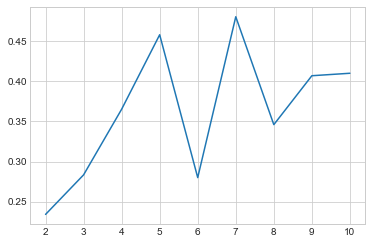

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

k_data = [x[0] for x in k_fixedab]
cv_data = [x[3] for x in k_fixedab]

fig = plt.figure()
ax = plt.axes()

ax.plot(k_data, cv_data)

7 topics yields the highest coherence - as expected from above

In [120]:
print("most optimised values:" + " K: " + str(k_m) + " a: " + str(a_m) + " b: " + str(b_m) + " cv: " + str(cv_m))

most optimised values: K: 7 a: 0.7000000000000001 b: 0.7000000000000001 cv: 0.4808453369121811


In [122]:
percent = (cv_m/coherence_lda)-1
print(percent * 100)

2.9200589254876563


redo the lda with the new values

In [123]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k_m, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a_m,
                                           eta=b_m)

In [124]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

c:\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.035537 -0.096708       1        1  41.539818
0      0.103527  0.061609       2        1  27.967489
2      0.039161 -0.022028       3        1  14.512362
4     -0.024258  0.027300       4        1   9.975726
6     -0.064777  0.004257       5        1   5.908651
3     -0.043632  0.012496       6        1   0.048023
1     -0.045557  0.013075       7        1   0.047933, topic_info=     Category        Freq        Term       Total  loglift  logprob
1728  Default   53.000000       curve   53.000000  30.0000  30.0000
870   Default   51.000000     pathway   51.000000  29.0000  29.0000
1518  Default   53.000000        unit   53.000000  28.0000  28.0000
91    Default   56.000000     cluster   56.000000  27.0000  27.0000
584   Default  113.000000         set  113.000000  26.0000  26.0000
...       ...         ...         ...         ...      ...      ...
400    Topic7    0.003314        make   27.875090  -1.3941  -7.7697
663    Topic7    0.003309  time_serie   24.553726  -1.2688  -7.7713
589    Topic7    0.003333        show   52.325333  -2.0181  -7.7640
226    Topic7    0.003331     example   48.208466  -1.9369  -7.7647
782    Topic7    0.003329       error  103.514122  -2.7017  -7.7653

[421 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1242      1  0.825530       account
1242      2  0.091726       account
1243      1  0.147236      accuracy
1243      2  0.785261      accuracy
1243      3  0.049079      accuracy
...     ...       ...           ...
1707      2  0.248918          wall
1707      4  0.497835          wall
2071      1  0.103794  weight_decay
2071      2  0.103794  weight_decay
2071      3  0.830348  weight_decay

[849 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 5, 7, 4, 2])